In [260]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from tqdm.notebook import tqdm

In [386]:
e = 0.04

In [387]:
beta = 0.01
k = 4
N = 10000

In [388]:
T = 600

In [389]:
Q = np.array([[1-e, e], [e, 1-e]])

In [390]:
phi0 = np.array([1/N, 0])

In [391]:
def dphi_dt(t, phi):
    return beta * k * (1 - np.sum(phi)) * (Q @ phi)

In [392]:
test = integrate.solve_ivp(dphi_dt, [0,T], phi0)

In [446]:
type(test)

scipy.integrate._ivp.ivp.OdeResult

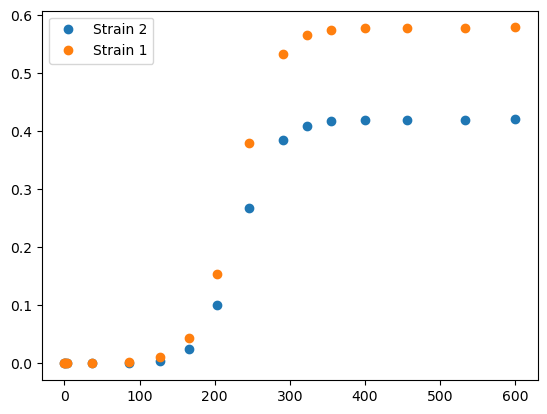

In [274]:
plt.plot(test.t, test.y[1], 'o', label="Strain 2")
plt.plot(test.t, test.y[0], 'o', label="Strain 1")
plt.legend()

In [447]:
test.t

array([0.00000000e+00, 3.32225407e-01, 3.65447947e+00, 3.68770201e+01,
       8.48723776e+01, 1.25880667e+02, 1.64519547e+02, 2.02213385e+02,
       2.43297140e+02, 2.87428400e+02, 3.12377578e+02, 3.37326755e+02,
       3.81249811e+02, 4.29970156e+02, 4.97265308e+02, 5.88748449e+02,
       6.00000000e+02])

## Non-Autonomous $\phi$

## Continuous Gillespie

In [440]:
eps = 1e-6
def dphi_dt_nonauto(t, phi, phi0):
    return beta * k * (1 - (phi0*np.exp(t/(beta*k + eps)) / (1 + (np.exp(t/(beta*k + eps)) - 1)))) * (Q @ phi)

In [399]:
class NoisyGillespie:
    
    def __init__(self, N, initial_state, beta, k, channel):
        self.N = N
        self.state = np.array(initial_state)
        self.beta = beta
        self.k = k
        self.channel = channel
        self.time = 0.0
        self.history = [(self.time, self.state.copy())]
        

    def propensities(self):
            
        return beta * self.k * (self.N - np.sum(self.state)) * (self.channel @ self.state)

    def step(self):
        a = self.propensities()
        a0 = a.sum()
        if a0 == 0:
            return False  # No more events can happen
        
        # Time to next event
        tau = np.random.exponential(self.N / a0)
        
        # Determine which event occurs
        r = np.random.uniform(0, a0)

        event = np.searchsorted(np.cumsum(a), r)
        
        for e in range(a.shape[0]):
            if event == e:
                self.state[e] += 1 # increase the value of the infection corresponding to the selected event

        # Update time
        self.time += tau
        self.history.append((self.time, self.state.copy()))
        return True

    def simulate(self, max_time, max_steps=int(1e6)):
        steps = 0
        while (self.time < max_time and steps < max_steps and 
               np.sum(self.state) <= self.N ):  # As long as not everybody has been infected
            if not self.step():
                break
            steps += 1
        return self.history



In [443]:
test_nonauto = integrate.solve_ivp(dphi_dt_nonauto, [0,100], phi0, args=[phi0],  method='RK45')

/tmp/ipykernel_509104/2984095573.py:3: RuntimeWarning: overflow encountered in exp
  return beta * k * (1 - (phi0*np.exp(t/(beta*k + eps)) / (1 + (np.exp(t/(beta*k + eps)) - 1)))) * (Q @ phi)
/tmp/ipykernel_509104/2984095573.py:3: RuntimeWarning: invalid value encountered in multiply
  return beta * k * (1 - (phi0*np.exp(t/(beta*k + eps)) / (1 + (np.exp(t/(beta*k + eps)) - 1)))) * (Q @ phi)
/tmp/ipykernel_509104/2984095573.py:3: RuntimeWarning: invalid value encountered in divide
  return beta * k * (1 - (phi0*np.exp(t/(beta*k + eps)) / (1 + (np.exp(t/(beta*k + eps)) - 1)))) * (Q @ phi)


In [406]:
initial_state_ng = np.array([1, 0])

# Create the Gillespie simulation object
gillespie = NoisyGillespie(N=N, initial_state=initial_state_ng, beta=beta, k=k, channel=Q)

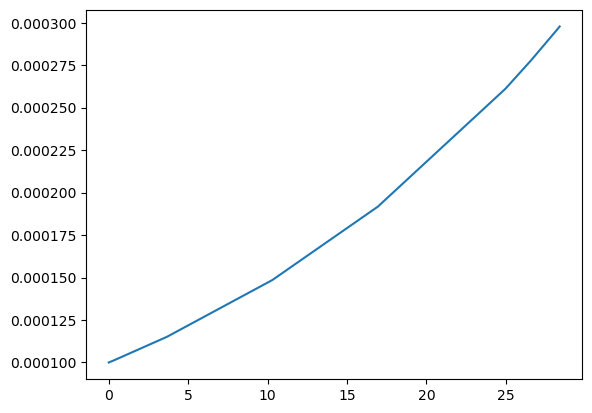

In [444]:
plt.plot(test_nonauto.t, test_nonauto.y[0])

In [407]:
history = gillespie.simulate(1500)

In [408]:
history

[(0.0, array([1, 0])),
 (0.9985762633053366, array([2, 0])),
 (2.85647411582717, array([3, 0])),
 (8.113113516459581, array([4, 0])),
 (8.977883796200208, array([5, 0])),
 (9.22039053774828, array([6, 0])),
 (12.967289092930958, array([7, 0])),
 (16.993054212219874, array([8, 0])),
 (26.541474679780368, array([9, 0])),
 (26.814589022232237, array([10,  0])),
 (29.011879380551985, array([11,  0])),
 (32.55569940644905, array([12,  0])),
 (33.22727235929336, array([12,  1])),
 (33.44661960960592, array([13,  1])),
 (33.51621679325531, array([14,  1])),
 (34.21323363994701, array([15,  1])),
 (38.05381412057903, array([16,  1])),
 (39.45848606827545, array([17,  1])),
 (39.804190376608126, array([18,  1])),
 (44.621903049351886, array([19,  1])),
 (45.25457458837665, array([20,  1])),
 (45.957541603555036, array([21,  1])),
 (46.93656722827416, array([22,  1])),
 (47.29804618798326, array([23,  1])),
 (47.39685199219965, array([24,  1])),
 (49.32732503080943, array([25,  1])),
 (49.378144

In [409]:
comp = integrate.solve_ivp(dphi_dt, [0,600], phi0)

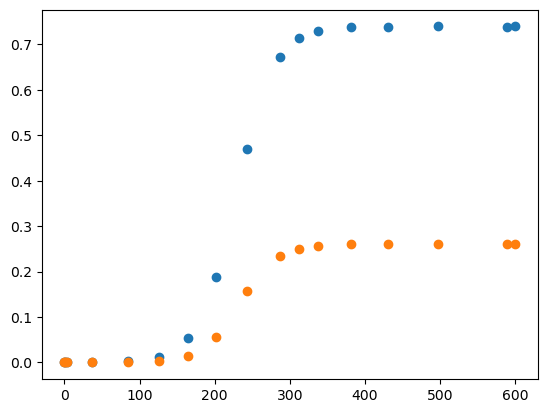

In [410]:
plt.plot(comp.t, comp.y[0], 'o')
plt.plot(comp.t, comp.y[1], 'o')

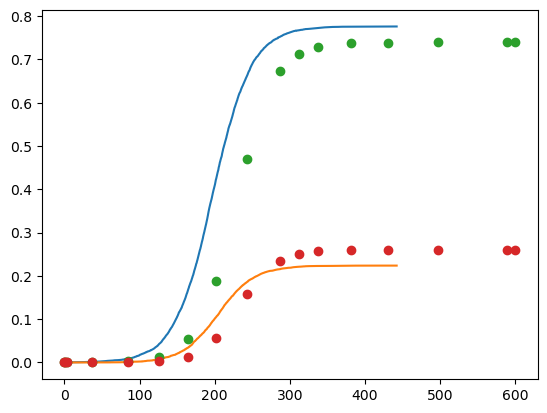

In [411]:
gills = gillespie.simulate(1000)
gilly_len = len(gills)
plt.plot([i[0] for i in gills], [i[1][0]/N for i in gills])
plt.plot([i[0] for i in gills], [i[1][1]/N for i in gills])
plt.plot(comp.t, comp.y[0], 'o')
plt.plot(comp.t, comp.y[1], 'o')

## Iterations

In [207]:
history

[(0.0, array([1, 0])),
 (0.33544407949660876, array([2, 0])),
 (0.881288735712457, array([2, 1])),
 (0.9783777101847371, array([3, 1])),
 (0.9834373037538373, array([4, 1])),
 (0.9890721919372826, array([5, 1])),
 (0.997164908244716, array([6, 1])),
 (1.026027798602212, array([7, 1])),
 (1.0408132098867613, array([8, 1])),
 (1.0511928480743848, array([9, 1])),
 (1.0550831359415491, array([10,  1])),
 (1.0564557998962014, array([11,  1])),
 (1.0766356774359456, array([12,  1])),
 (1.1068607475703196, array([13,  1])),
 (1.113371448252386, array([14,  1])),
 (1.1860464718297814, array([15,  1])),
 (1.196084885583388, array([15,  2])),
 (1.2175193507295545, array([16,  2])),
 (1.2716804023420347, array([16,  3])),
 (1.3011831232113795, array([17,  3])),
 (1.364878687159257, array([18,  3])),
 (1.3878965982435516, array([18,  4])),
 (1.4081642179427445, array([18,  5])),
 (1.4254887862597156, array([19,  5])),
 (1.468964297942295, array([19,  6])),
 (1.4796184772771421, array([20,  6])),
 

In [243]:
history 

[(0.0, array([1, 0])),
 (0.1051836595762051, array([2, 0])),
 (0.16523332229020263, array([3, 0])),
 (0.5357953729359826, array([4, 0])),
 (0.578632712623672, array([5, 0])),
 (0.6068106743017978, array([6, 0])),
 (0.6263384291507064, array([7, 0])),
 (0.7027486760396889, array([8, 0])),
 (0.7515673006848003, array([9, 0])),
 (0.8745347762968491, array([10,  0])),
 (0.8849500076137837, array([11,  0])),
 (0.985729608623317, array([12,  0])),
 (1.0229497033291308, array([13,  0])),
 (1.0369643496236842, array([14,  0])),
 (1.0392189030067995, array([15,  0])),
 (1.0407662865151572, array([16,  0])),
 (1.04124420074909, array([17,  0])),
 (1.0458825248005477, array([18,  0])),
 (1.053219054393015, array([19,  0])),
 (1.071537325577937, array([20,  0])),
 (1.0791759711408229, array([21,  0])),
 (1.1179566294414982, array([22,  0])),
 (1.1491261599397764, array([23,  0])),
 (1.1668696166406871, array([24,  0])),
 (1.2062450987280349, array([25,  0])),
 (1.2928177033618424, array([26,  0]))

  0%|          | 0/100 [00:00<?, ?it/s]

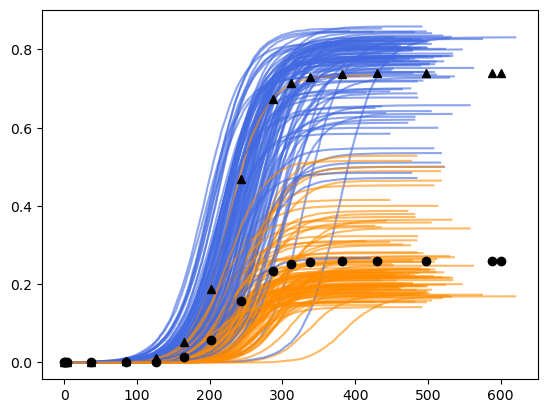

In [430]:
initial_state_ng = np.array([1, 0])

# Create the Gillespie simulation object
gillespie = NoisyGillespie(N=N, initial_state=initial_state_ng, beta=beta, k=k, channel=Q)

runs = list()
for _ in tqdm(range(100)):
    gillespie = NoisyGillespie(N=N, initial_state=initial_state_ng, beta=beta, k=k, channel=Q)
    runs.append(gillespie.simulate(1000))
    
for run in runs:
    plt.plot([i[0] for i in run], [i[1][0]/gillespie.N for i in run], alpha=0.6, color='royalblue')
    plt.plot([i[0] for i in run], [i[1][1]/gillespie.N for i in run], alpha=0.6, color='darkorange')
    
plt.plot(comp.t, comp.y[0], '^', color='k')
plt.plot(comp.t, comp.y[1], 'o', color='k')
    
#plt.ylim(0, 0.001)
#plt.xlim(0, 2)

  0%|          | 0/1 [00:00<?, ?it/s]

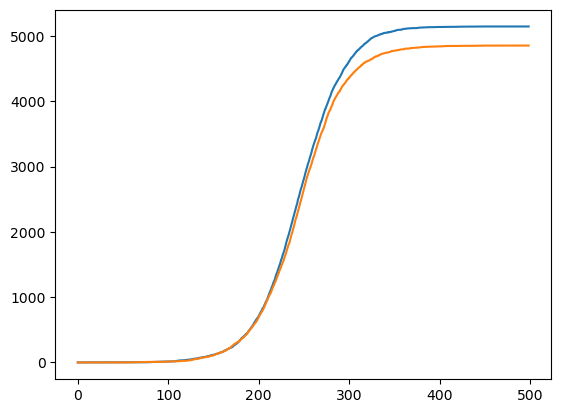

In [375]:
gilly_len = 0
for _ in tqdm(range(1)):
    gills = gillespie.simulate(1000)
    gilly_len = len(gills)
    plt.plot([i[0] for i in gills], [i[1][0] for i in gills])
    plt.plot([i[0] for i in gills], [i[1][1] for i in gills])
    
    

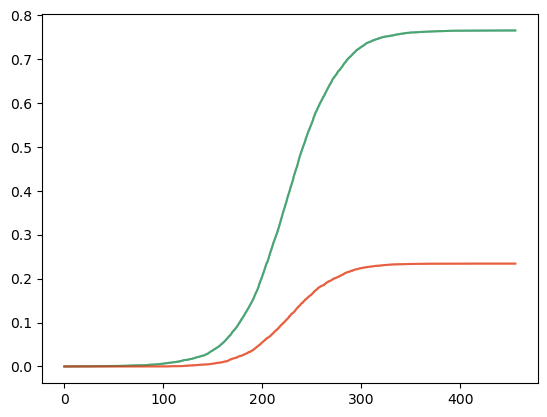

In [426]:
plt.plot([i[0] for i in runs[0]], [i[1][0]/gillespie.N for i in runs[0]], alpha=0.6)
plt.plot([i[0] for i in runs[0]], [i[1][1]/gillespie.N for i in runs[0]], alpha=0.6)
plt.plot([i[0] for i in runs[1]], [i[1][0]/gillespie.N for i in runs[1]], alpha=0.6)
plt.plot([i[0] for i in runs[1]], [i[1][1]/gillespie.N for i in runs[1]], alpha=0.6)

In [335]:
(1/0.0001)*np.log(1/0.02)

39120.23005428146

In [ ]:
# Initial conditions: S, I1, I2, R
initial_state = [999, 1, 0, 0]

# Rates: beta1, beta2, gamma1, gamma2
rates = [0.3, 0.2, 0.1, 0.1]

# Create the Gillespie simulation object
gillespie = NoisyGillespie(initial_state, rates)

# Run the simulation
history = gillespie.simulate(100)

# Plot the simulation results
history = np.array(history)
times = history[:, 0]
states = history[:, 1:]

plt.plot(times, states[:, 0], label='Susceptible')
plt.plot(times, states[:, 1], label='Infected Strain 1')
plt.plot(times, states[:, 2], label='Infected Strain 2')
plt.plot(times, states[:, 3], label='Recovered')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()